# How has Covid-19 being dictated by Socioeconomic factors in the Middlesex county?

In [6]:
# importing required packages

# data manipulation packages
import pandas as pd
import numpy as np
import datetime

# visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.figsize"] = (25,8)

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Data Acquisition

For this analysis, we will be importing 3 datasets.
1. Covid Cases dataset
2. Socioeconomic dataset I
3. Socioeconomic dataset II

### Covid Cases Dataset

The covid cases dataset contains the daily confirmed cases for all the counties in the United States. Since this analysis is focused on the Middlesex county, the dataset is filtered just for this Middlesex county, MA.

In [2]:
# fetching RAW_us_confirmed_cases.csv
us_confirmed_cases = pd.read_csv('data\RAW_us_confirmed_cases.csv')

# filtering the dataset for middlesex county
middlesex_confirmed_cases = us_confirmed_cases[(us_confirmed_cases['Admin2'] == 'Middlesex') & (us_confirmed_cases['Province_State'] == 'Massachusetts')]
middlesex_confirmed_cases

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22,11/1/22,11/2/22
1274,Massachusetts,Middlesex,84025017,US,USA,840,25017.0,US,42.486077,-71.390492,...,410737,410737,410737,412305,412305,412305,412305,412305,412305,412305


This above dataset is a single row, so restructing it to required format. 

Now, the first 20 columns provides just the general data about the middlesex county and the columns after that is the time series data. Hence, first splitting the data into part and then transforming the covid time series data from columnar data to row-wise.

In [3]:
# first 12 columns are general info about the state 
middlesex_general_info = middlesex_confirmed_cases[middlesex_confirmed_cases.columns[0:12]]

# confirmed cases time series 
county_df =  middlesex_confirmed_cases[middlesex_confirmed_cases.columns[12:]]
county_df = pd.DataFrame(county_df.iloc[0])
county_df = county_df.reset_index()
county_df.columns = ["date", "cases"]
county_df['date'] = pd.to_datetime(county_df['date'])
county_df.head()

,date,cases
0,2020-01-23,0
1,2020-01-24,0
2,2020-01-25,0
3,2020-01-26,0
4,2020-01-27,0


### Socioeconomic and Health Dataset I

Importing the socioeconomic & health time series dataset, this data provides the socioeconomic factors of all the counties in the United States. Fruthermore, again filtering this data for the Middlesex county. 

In [4]:
# fetching the socioeconomic dataset
sociohealth_df = pd.read_csv('data\\US_counties_COVID19_health_weather_data.csv')
sociohealth_df.head()

,date,county,state,fips,cases,deaths,stay_at_home_announced,stay_at_home_effective,lat,lon,...,min_temp_3d_avg,min_temp_5d_avg,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective
0,2020-01-21,Snohomish,Washington,53061,1,0.0,no,no,48.047489,-121.697307,...,38.266667,38.92,38.44,36.146667,40.333333,41.64,40.74,37.973333,2020-03-23,2020-03-23
1,2020-01-22,Snohomish,Washington,53061,1,0.0,no,no,48.047489,-121.697307,...,39.233333,41.12,39.76,37.613333,42.633333,42.98,41.68,39.440000,2020-03-23,2020-03-23
2,2020-01-23,Snohomish,Washington,53061,1,0.0,no,no,48.047489,-121.697307,...,42.900000,41.74,41.15,38.226667,44.733333,43.72,42.47,40.120000,2020-03-23,2020-03-23
3,2020-01-24,Cook,Illinois,17031,1,0.0,no,no,41.840039,-87.816716,...,32.366667,30.02,27.43,24.886667,31.433333,28.50,25.00,22.693333,2020-03-20,2020-03-21
4,2020-01-24,Snohomish,Washington,53061,1,0.0,no,no,48.047489,-121.697307,...,44.600000,42.54,41.75,38.226667,46.000000,44.30,42.88,41.293333,2020-03-23,2020-03-23


In [7]:
# filtering for the middlesex county in Massachusetts
county_sociohealth_df = sociohealth_df[(sociohealth_df['state'] == 'Massachusetts') & (sociohealth_df['county'] == 'Middlesex')]
county_sociohealth_df['date'] = pd.to_datetime(county_sociohealth_df['date'])
county_sociohealth_df.head()

,date,county,state,fips,cases,deaths,stay_at_home_announced,stay_at_home_effective,lat,lon,...,min_temp_3d_avg,min_temp_5d_avg,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective
552,2020-03-05,Middlesex,Massachusetts,25017,1,0.0,no,no,42.485587,-71.39179,...,34.700000,34.80,30.73,30.426667,25.166667,24.38,20.77,21.086667,2020-03-23,2020-03-24
611,2020-03-06,Middlesex,Massachusetts,25017,1,0.0,no,no,42.485587,-71.39179,...,27.666667,30.02,33.12,30.820000,17.466667,18.26,23.60,21.526667,2020-03-23,2020-03-24
696,2020-03-07,Middlesex,Massachusetts,25017,5,0.0,no,no,42.485587,-71.39179,...,23.000000,27.82,34.11,31.480000,13.066667,16.02,24.30,22.606667,2020-03-23,2020-03-24
797,2020-03-08,Middlesex,Massachusetts,25017,10,0.0,no,no,42.485587,-71.39179,...,26.366667,29.02,33.52,32.546667,11.900000,18.44,24.51,22.860000,2020-03-23,2020-03-24
920,2020-03-09,Middlesex,Massachusetts,25017,15,0.0,no,no,42.485587,-71.39179,...,33.033333,32.62,32.90,32.866667,20.266667,20.50,23.64,23.040000,2020-03-23,2020-03-24


### Socioeconomic Dataset II

Importing the second socioeconomic dataset which is just the various constant variables for each county.

In [10]:
# importing the data
county_socio_df = pd.read_csv('data\\us_county_sociohealth_data.csv')
county_socio_df.head()

,fips,state,county,lat,lon,total_population,area_sqmi,population_density_per_sqmi,num_deaths,years_of_potential_life_lost_rate,...,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability
0,01001,Alabama,Autauga,32.534928,-86.642748,55049,594.446120,92.605533,791.0,8128.591190,...,0.6339,0.5355,0.5976,0.6791,0.7268,0.2477,0.3298,0.1251,0.2881,0.3773
1,01003,Alabama,Baldwin,30.727489,-87.722575,199510,1589.807425,125.493187,2967.0,7354.122530,...,0.5253,0.5282,0.5294,0.9733,0.5387,0.2639,0.0872,0.3438,0.3324,0.2757
2,01005,Alabama,Barbour,31.869589,-85.393213,26614,884.875776,30.076538,472.0,10253.573403,...,0.9042,0.6979,0.8558,0.2814,0.9370,0.4438,0.8816,0.9427,0.9312,0.9847
3,01007,Alabama,Bibb,32.998634,-87.126480,22572,622.582355,36.255444,471.0,11977.539484,...,0.6450,0.3553,0.5018,0.4072,0.9249,0.0248,0.5645,0.9156,0.6663,0.5737
4,01009,Alabama,Blount,33.980878,-86.567383,57704,644.806508,89.490412,1085.0,11335.071134,...,0.4238,0.7482,0.5992,0.1344,0.8465,0.5056,0.1907,0.1515,0.1827,0.4986


Since this data is constant attributes for all the counties and alone they do not add much values, so I will comapre these attirubtes of Middlesex county with the rest of the counties in the state of Massachusetts. Hence, filtering the data for the Massachusetts state and getting the list of all the counties in Massachusetts.

In [11]:
# filtering the data for Massachusetts
sociohealth_MA = county_socio_df[(county_socio_df['state'] == 'Massachusetts')]
sociohealth_MA

,fips,state,county,lat,lon,total_population,area_sqmi,population_density_per_sqmi,num_deaths,years_of_potential_life_lost_rate,...,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability
1217,25001,Massachusetts,Barnstable,41.724187,-70.291491,214703,394.206240,544.646376,2798.0,7302.693380,...,0.3451,0.4744,0.3954,0.6638,0.0181,0.1172,0.4537,0.2818,0.0930,0.0691
1218,25003,Massachusetts,Berkshire,42.370711,-73.206349,128563,926.906912,138.701091,1765.0,7541.421333,...,0.3773,0.6600,0.5212,0.8083,0.0888,0.1012,0.8848,0.8217,0.5912,0.4148
1219,25005,Massachusetts,Bristol,41.797454,-71.114770,554868,553.084364,1003.224890,6969.0,7289.844657,...,0.5158,0.8895,0.7459,0.8580,0.0462,0.2709,0.9341,0.6714,0.6342,0.5403
1220,25007,Massachusetts,Dukes,41.387875,-70.628025,17137,103.265273,165.951240,183.0,4820.134176,...,0.4416,0.8061,0.6428,0.2528,0.0032,0.0911,0.0420,0.3760,0.0067,0.0169
1221,25009,Massachusetts,Essex,42.673200,-70.952186,769362,492.418905,1562.413612,7915.0,5995.836548,...,0.6695,0.9319,0.8555,0.9484,0.0223,0.5435,0.9277,0.5788,0.7587,0.4826
1222,25011,Massachusetts,Franklin,42.583099,-72.591831,70916,699.212440,101.422681,888.0,6315.107787,...,0.3200,0.6288,0.4639,0.7529,0.1025,0.1493,0.6297,0.5702,0.3311,0.1729
1223,25013,Massachusetts,Hampden,42.135108,-72.631589,468072,617.043678,758.571908,5749.0,7418.746127,...,0.7584,0.9204,0.8892,0.9131,0.0408,0.6619,0.9701,0.6816,0.8676,0.8230
1224,25015,Massachusetts,Hampshire,42.340167,-72.663802,161035,527.227250,305.437551,1426.0,5480.236909,...,0.4989,0.5530,0.5285,0.8886,0.0408,0.1732,0.7740,0.9675,0.6708,0.2194
1225,25017,Massachusetts,Middlesex,42.485587,-71.391790,1567610,817.708812,1917.076076,12483.0,4384.115744,...,0.6533,0.8883,0.8246,0.9729,0.0146,0.4709,0.9163,0.7456,0.8128,0.2321
1226,25019,Massachusetts,Nantucket,41.282301,-70.062453,10694,46.112807,231.909543,88.0,4173.372859,...,0.6415,0.8395,0.7880,0.0634,0.0605,0.8672,0.7880,0.6135,0.4244,0.0939


In [12]:
# dropping the unrequired columns
drop = [ 'state', 'fips', 'lat', 'lon']
sociohealth_MA = sociohealth_MA.drop(columns=drop)

In [13]:
# getting the list of all the counties in Massachusetts
MA_counties = sociohealth_MA['county'].unique().tolist()
MA_counties

['Barnstable',
 'Berkshire',
 'Bristol',
 'Dukes',
 'Essex',
 'Franklin',
 'Hampden',
 'Hampshire',
 'Middlesex',
 'Nantucket',
 'Norfolk',
 'Plymouth',
 'Suffolk',
 'Worcester']

## Data Manipulation

Now from the data acquisition step, we have all our required data. To recall, the dataframes we gather from the previous step are -
1. `county_df` - daily covid cases in Middlesex
2. `county_sociohealth_df` - daily socioeconomic and weather values in Middlesex 
3. `sociohealth_MA` - socioeconomic and weather values in Massuchusetts

Now, we will transform and merge the above dataframes so that we can use the data to gather insights.

1. merging both the data
2. calculating cases per 100k
2. ordinal to numeric for correlation matrix
check for biases?

In [14]:
# dropping unrequired columns
dropcols = ['county', 'state', 'fips', 'cases', 'deaths', 'lat', 'lon', 'station_name', \
            'CALL', 'total_population', 'area_sqmi', 'population_density_per_sqmi']
county_sociohealth_df.drop(columns=dropcols, inplace = True)
county_sociohealth_df.head()

,date,stay_at_home_announced,stay_at_home_effective,num_deaths,years_of_potential_life_lost_rate,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,...,min_temp_3d_avg,min_temp_5d_avg,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective
552,2020-03-05,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,9.954443,...,34.700000,34.80,30.73,30.426667,25.166667,24.38,20.77,21.086667,2020-03-23,2020-03-24
611,2020-03-06,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,9.954443,...,27.666667,30.02,33.12,30.820000,17.466667,18.26,23.60,21.526667,2020-03-23,2020-03-24
696,2020-03-07,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,9.954443,...,23.000000,27.82,34.11,31.480000,13.066667,16.02,24.30,22.606667,2020-03-23,2020-03-24
797,2020-03-08,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,9.954443,...,26.366667,29.02,33.52,32.546667,11.900000,18.44,24.51,22.860000,2020-03-23,2020-03-24
920,2020-03-09,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,9.954443,...,33.033333,32.62,32.90,32.866667,20.266667,20.50,23.64,23.040000,2020-03-23,2020-03-24


In [15]:
# checking the shape of both the dataset
print("Covid cases dataframe shape: " + str(county_df.shape) + "\n" + \
    "Socio-economic and health dataset shape: " + str(county_sociohealth_df.shape))

Covid cases dataframe shape: (1015, 2)
Socio-economic and health dataset shape: (275, 215)


Merging the covid and socioeconomic time series dataset.

In [17]:
# merging the two dataframes
df = pd.merge(county_df, county_sociohealth_df, on = 'date')
df.head()

,date,cases,stay_at_home_announced,stay_at_home_effective,num_deaths,years_of_potential_life_lost_rate,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,...,min_temp_3d_avg,min_temp_5d_avg,min_temp_10d_avg,min_temp_15d_avg,dewpoint_3d_avg,dewpoint_5d_avg,dewpoint_10d_avg,dewpoint_15d_avg,date_stay_at_home_announced,date_stay_at_home_effective
0,2020-03-05,5,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,...,34.700000,34.80,30.73,30.426667,25.166667,24.38,20.77,21.086667,2020-03-23,2020-03-24
1,2020-03-06,10,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,...,27.666667,30.02,33.12,30.820000,17.466667,18.26,23.60,21.526667,2020-03-23,2020-03-24
2,2020-03-07,30,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,...,23.000000,27.82,34.11,31.480000,13.066667,16.02,24.30,22.606667,2020-03-23,2020-03-24
3,2020-03-08,39,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,...,26.366667,29.02,33.52,32.546667,11.900000,18.44,24.51,22.860000,2020-03-23,2020-03-24
4,2020-03-09,42,no,no,12483.0,4384.115744,10.844167,3.033135,3.451825,7.169388,...,33.033333,32.62,32.90,32.866667,20.266667,20.50,23.64,23.040000,2020-03-23,2020-03-24


We have merged the dataset. Let's check for any empty columns.

In [22]:
# checking for empty columns 
df.loc[:, df.isna().any()].columns

Index(['average_grade_performance', 'average_grade_performance_2',
       'percent_enrolled_in_free_or_reduced_lunch', 'wind_gust',
       'precipitation', 'precip_flag', 'mean_temp_3d_avg', 'mean_temp_5d_avg',
       'mean_temp_10d_avg', 'mean_temp_15d_avg', 'max_temp_3d_avg',
       'max_temp_5d_avg', 'max_temp_10d_avg', 'max_temp_15d_avg',
       'min_temp_3d_avg', 'min_temp_5d_avg', 'min_temp_10d_avg',
       'min_temp_15d_avg', 'dewpoint_3d_avg', 'dewpoint_5d_avg',
       'dewpoint_10d_avg', 'dewpoint_15d_avg'],
      dtype='object')

Now, there are moving avg columns in this list, and we can't get rid of them as they will have Nan. However, we can get rid of the other columns. 

In [23]:
df = df.drop(columns = ['average_grade_performance', 'average_grade_performance_2', 'percent_enrolled_in_free_or_reduced_lunch', 'precip_flag'])

There are a lot of columns with categorical data. So first listing them and transforming it into numerical.

In [24]:
# gettinng numeric columns
num_cols = df._get_numeric_data().columns
cols = df.columns

# subtracting numeric columns from the list of all columns
list(set(cols) - set(num_cols))

['stay_at_home_announced',
 'date_stay_at_home_announced',
 'date_stay_at_home_effective',
 'stay_at_home_effective',
 'date',
 'presence_of_water_violation']

From the above list, we are going to convert the columns `'date_stay_at_home_announced', 'date_stay_at_home_effective', 'presence_of_water_violation'` into numeric. We will not convert others as they are date columns.

In [ ]:
# mapping yes with 1 and no with 0 for the categorical columns
mapping = {'yes': 1, 'no': 0}

df['presence_of_water_violation'] = df['presence_of_water_violation'].map(mapping)
df['stay_at_home_effective'] = df['stay_at_home_effective'].map(mapping)
df['stay_at_home_announced'] = df['stay_at_home_announced'].map(mapping)

Upon further investigating the data manually, I found that the few of the column values are same throughout. So they are a constant valued columns. Hence, getting the list of those columns and saivng it into a new csv file at `./data/output/middlesex_variables.csv`.

In [25]:
# fetching columns with only one constant value throughout
const_col = df.columns[df.nunique() <= 1].tolist()

# creating a dataframe with the const variables and its value
const_df = pd.DataFrame(df[const_col].iloc[0])
const_df.rename(columns={0:'val'}, inplace = True)
const_df

,val
num_deaths,12483.0
years_of_potential_life_lost_rate,4384.115744
percent_fair_or_poor_health,10.844167
average_number_of_physically_unhealthy_days,3.033135
average_number_of_mentally_unhealthy_days,3.451825
...,...
station_id,72505914702.0
hail,0.0
tornado,0.0
date_stay_at_home_announced,2020-03-23


In [26]:
# removing the constant columns from the main dataframe
df = df.drop(columns = const_col)

In [28]:
# exporting the const df to an external csv
const_df.to_csv('./data/output_data/middlesex_variables.csv')

Till now I have manipulated and curated the mentioned dataframe. Now to understand the socioeconomic factors relationship with the covid cases for each county in Massuchusetts, we need to fetch the covid cases in the MA and then merge this with the socioecomoic dataset for each county in MA.

In [30]:
# fetching covid cases for the state of Massuchusetts
MAcases = us_confirmed_cases[(us_confirmed_cases['Province_State'] == 'Massachusetts') & (us_confirmed_cases['Admin2'].isin(MA_counties))]

# dropping unrequired columns
MAcases.drop(MAcases.columns[[0, 2,3,4,5,6,7,8,9,10,11,12]], axis = 1, inplace=True)

# gettting mean covid cases for each county
MAcases = MAcases.set_index('Admin2')
MA_confirmed_cases = pd.DataFrame(MAcases.mean(axis = 'columns'), columns=['cases'])
# MA_confirmed_cases.sort_values(by='cases')

# merging the above df with socioeconomic data
counties = pd.merge(MA_confirmed_cases, sociohealth_MA, left_on='Admin2', right_on='county')
counties.head()

,cases,county,total_population,area_sqmi,population_density_per_sqmi,num_deaths,years_of_potential_life_lost_rate,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,...,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability
0,17226.780079,Barnstable,214703,394.206240,544.646376,2798.0,7302.693380,10.040827,3.151688,3.863676,...,0.3451,0.4744,0.3954,0.6638,0.0181,0.1172,0.4537,0.2818,0.0930,0.0691
1,10734.547337,Berkshire,128563,926.906912,138.701091,1765.0,7541.421333,13.207584,3.567795,3.940257,...,0.3773,0.6600,0.5212,0.8083,0.0888,0.1012,0.8848,0.8217,0.5912,0.4148
2,74698.960552,Bristol,554868,553.084364,1003.224890,6969.0,7289.844657,14.342738,3.718130,4.246295,...,0.5158,0.8895,0.7459,0.8580,0.0462,0.2709,0.9341,0.6714,0.6342,0.5403
3,0.000000,Dukes,17137,103.265273,165.951240,183.0,4820.134176,11.056612,3.118073,3.797607,...,0.4416,0.8061,0.6428,0.2528,0.0032,0.0911,0.0420,0.3760,0.0067,0.0169
4,106724.807692,Essex,769362,492.418905,1562.413612,7915.0,5995.836548,13.395284,3.470228,3.563415,...,0.6695,0.9319,0.8555,0.9484,0.0223,0.5435,0.9277,0.5788,0.7587,0.4826


## Data Analysis

In this analysis the movement of socioeconomic factors and how did they affect the covid cases. So we will try to understand the correlations between them and how the past values are affecting the current cases.

### Correlation Analysis

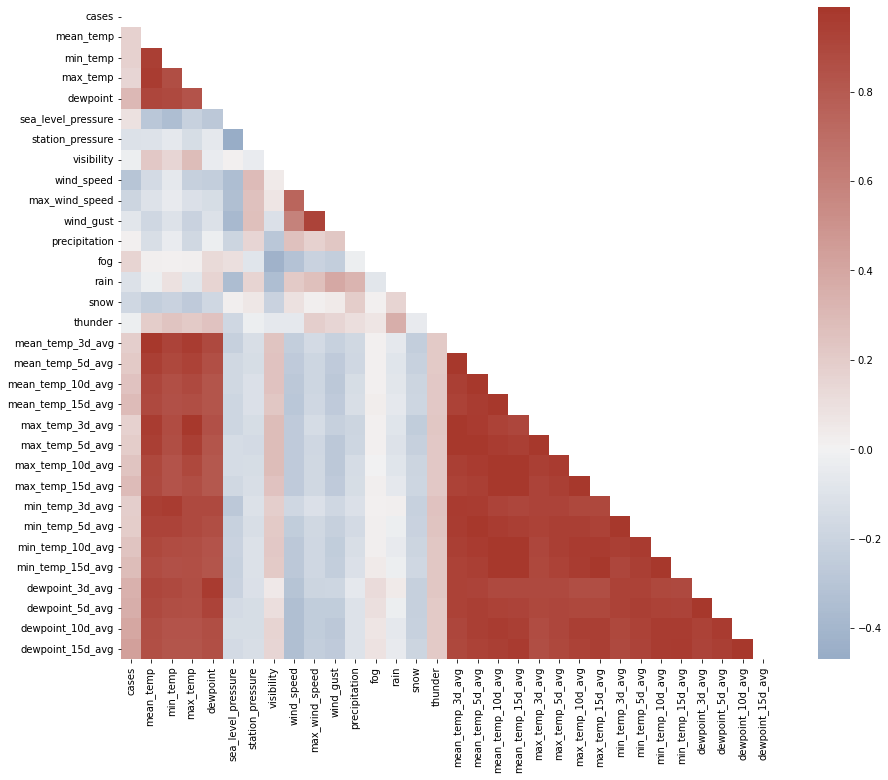

In [31]:
# Calculate pairwise-correlation
corr = df.drop(columns = 'date').corr().round(2)

# Create a mask
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

plt.figure(figsize=(16, 12))
sns.heatmap(corr, mask=mask, center=0, fmt='.2f', square=True, cmap=cmap)

plt.show()

In [34]:
#Correlation with output variable
cor_target = abs(corr["cases"])

#Selecting correlated features i.e., with no zero correlations
relevant_features = cor_target[cor_target != 0]
relevant_features.to_csv('./data/output_data/correlated_features.csv')

Now, we have some features that are correlated to the covid cases. So we will try to interpret them now.

In [33]:
relevant_features.sort_values(ascending=False)

cases                 1.00
dewpoint_15d_avg      0.44
dewpoint_10d_avg      0.40
dewpoint_5d_avg       0.36
dewpoint_3d_avg       0.34
dewpoint              0.30
wind_speed            0.30
max_temp_15d_avg      0.29
mean_temp_15d_avg     0.29
min_temp_15d_avg      0.28
mean_temp_10d_avg     0.25
min_temp_10d_avg      0.24
max_temp_10d_avg      0.24
mean_temp_5d_avg      0.21
max_wind_speed        0.20
min_temp_5d_avg       0.20
max_temp_5d_avg       0.20
min_temp_3d_avg       0.19
mean_temp_3d_avg      0.19
max_temp_3d_avg       0.18
snow                  0.18
mean_temp             0.17
min_temp              0.17
fog                   0.16
max_temp              0.15
rain                  0.11
station_pressure      0.11
sea_level_pressure    0.09
wind_gust             0.08
thunder               0.03
visibility            0.03
precipitation         0.01
Name: cases, dtype: float64

### Lag Analysis

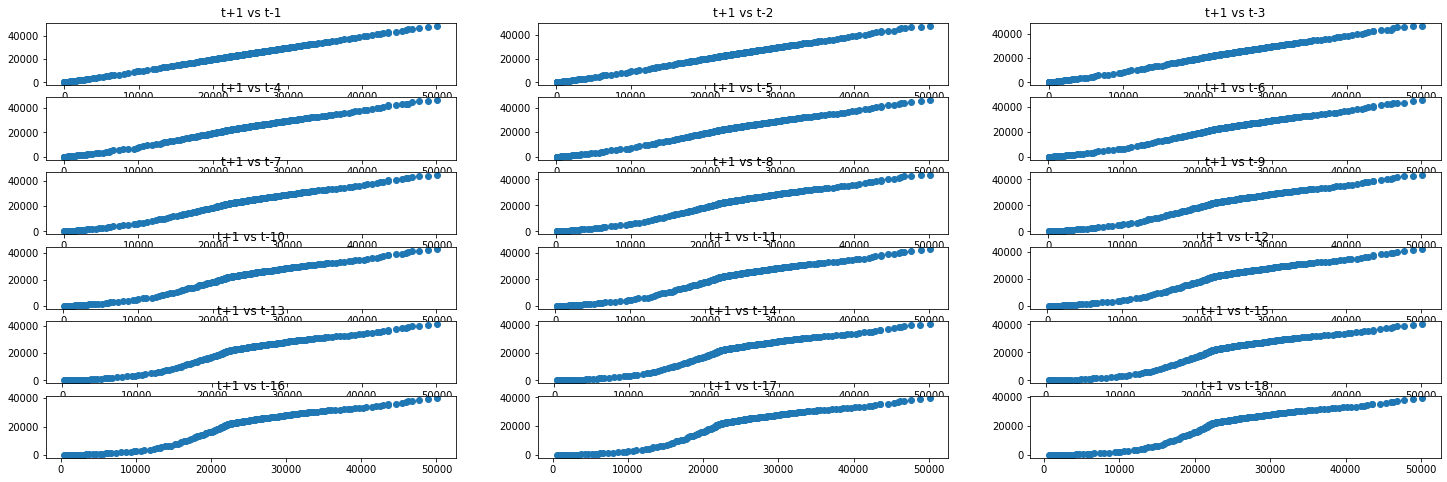

In [35]:
lags = 18
values = df['cases']
columns = [values]
for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

dataframe = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))

dataframe.columns = columns
plt.figure(1)

for i in range(1,(lags + 1)):
    ax = plt.subplot(6, 3, i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=dataframe['t+1'].values, y=dataframe['t-'+str(i)].values)

plt.show()

In the above plot, the plots shows a linear pattern between confirmed cases and it's 14-day lagged, it suggests autocorrelation is present. A positive linear trend (i.e. going upwards from left to right) is suggestive of positive autocorrelation. Morever, The tighter the data is clustered around the diagonal, the more autocorrelation is present.

This plot confirms that the current cases is highly correlated with the last 14-days of plot

### Cross-correlation Analysis

Text(0.5, 1.0, 'Cross-Relation Graph')

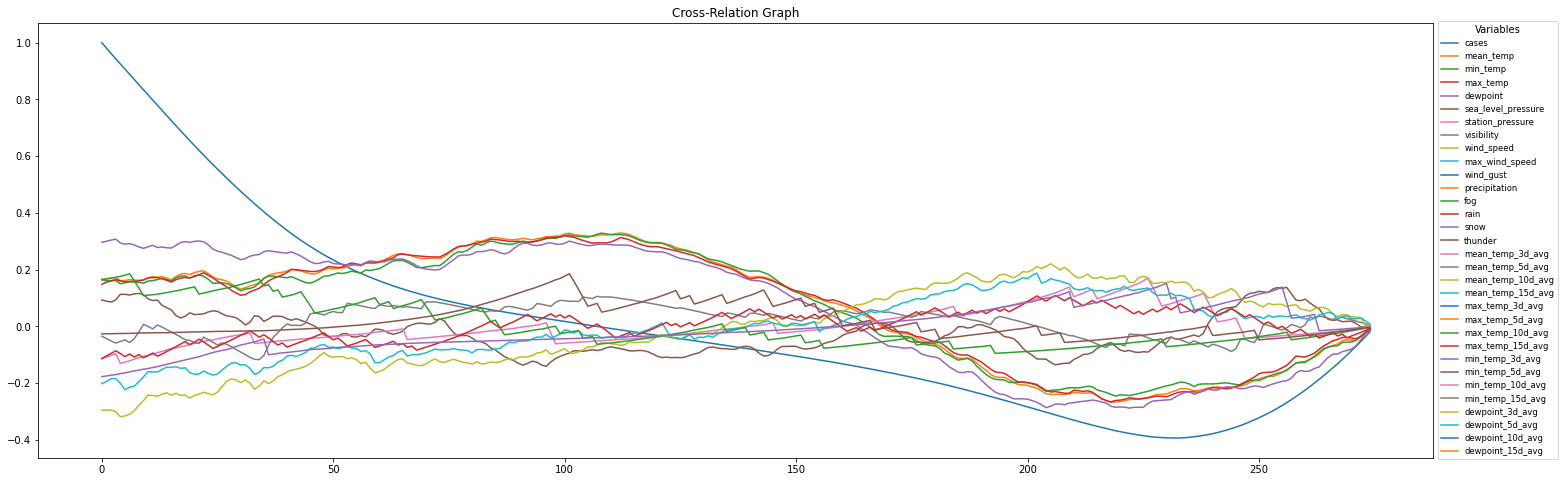

In [36]:
#calculate cross correlation
for cols in relevant_features.index:
    plt.plot(sm.tsa.stattools.ccf(df['cases'], df[cols], adjusted=False))

plt.legend(relevant_features.index, title = 'Variables', loc='center left', fontsize='small', fancybox=True, bbox_to_anchor = (1, 0.5))
plt.title("Cross-Relation Graph")

### Plotting the Covid cases along with the indiacation of when the stay-in policy was implemented


Text(0.5, 1.0, 'Covid Cases')

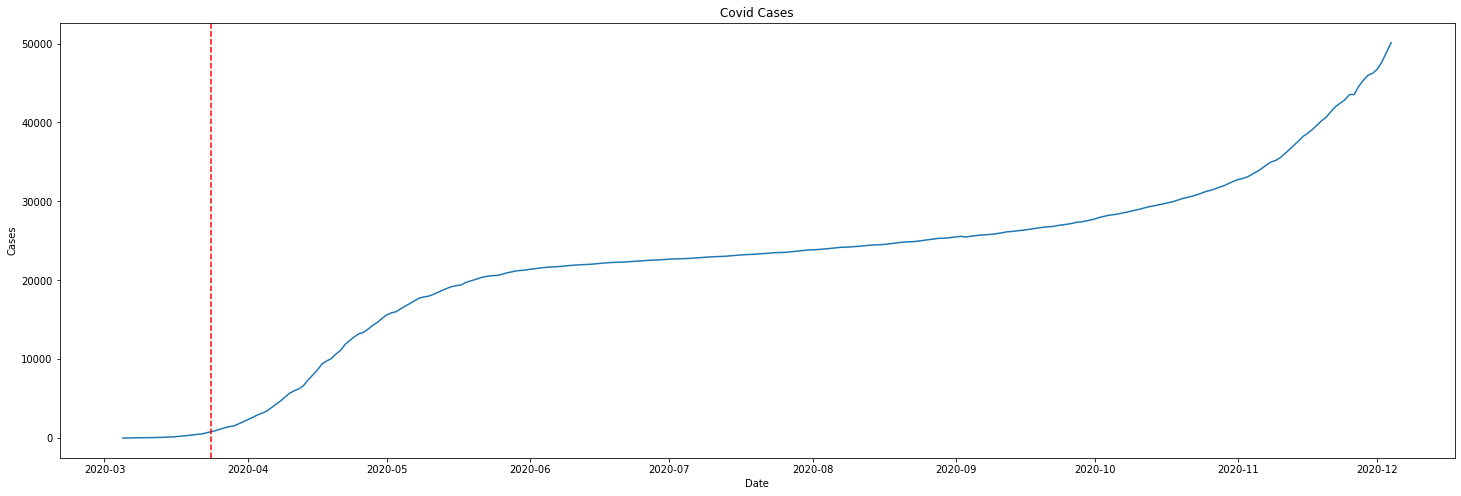

In [37]:
plt.plot(df['date'], df['cases'])
datestr = const_df[const_df.index == 'date_stay_at_home_effective']['val'].values[0]
plt.axvline(x = datetime.datetime.strptime(datestr, "%Y-%m-%d").date(), color = 'red', linestyle = '--')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Covid Cases')

### Relationship of Covid cases with socioeconomic factors in the state of Massuchusetts.

The socioeconomic factors considered in here are - 
- economic factors
- health factors
- weather factors

UFuncTypeError: Cannot cast ufunc 'svd_n_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

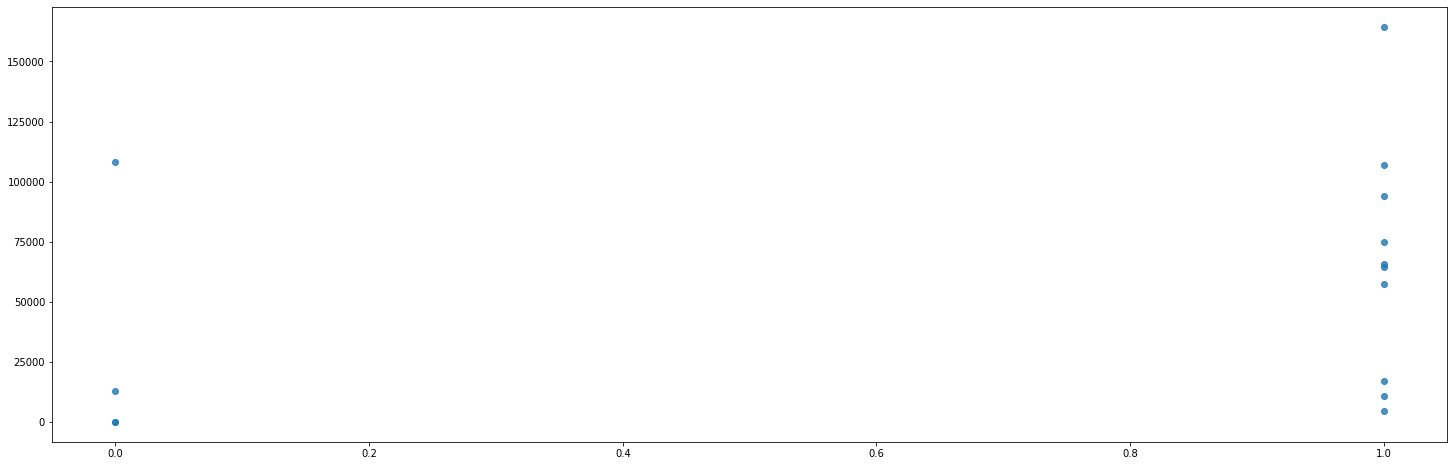

In [38]:
for col in sociohealth_MA.columns[1:]:
    sns.regplot(x = col, y='cases', data = counties)
    plt.scatter(counties.at[df.index[8],col], counties.at[df.index[8],'cases'], color="red")
    # add text annotation
    plt.text(counties.at[df.index[8],col]+0.2, counties.at[df.index[8],'cases'], "Middlesex", horizontalalignment='left', size='medium', color='black', weight='semibold')
    plt.title("Confirmed Cases Vs " + col)
    plt.savefig('pic/relational_pic/' + str(col) + '.png', format = 'PNG')
    plt.close('all')